In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import PIL
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Flatten, Rescaling, Conv2D, MaxPooling2D
import os
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# mount google drive to save images on it
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# it can be removed for saving images to tmp colab buffer 'content/'
# but saving images to colab buffer takes a lot of RAM
os.chdir('/content/drive/MyDrive/Lamoda classification images')
os.getcwd()

'/content/drive/MyDrive/Lamoda classification images'

In [ ]:
os.listdir()

['images_lamoda_products.csv', 'images', 'model_on_GPU_full_dataset.h5']

In [ ]:
path_bluzy = '/content/drive/MyDrive/Lamoda classification images/images/bluzy/'
path_bryuki = '/content/drive/MyDrive/Lamoda classification images/images/bryuki/'
print(f"Amount of bluzy images {len(os.listdir(path_bluzy))}")
print(f"Amount of bryuki images {len(os.listdir(path_bryuki))}")

Amount of bluzy images 8842
Amount of bryuki images 8003


In [ ]:
df = pd.read_csv('images_lamoda_products.csv')

df

,img_name,img_shape,class
0,clothes-bluzy_BA007EWDXAQ4_8606972.jpg,"(866, 600, 3)",bluzy
1,clothes-bluzy_BA007EWDXAQ6_8606164.jpg,"(66, 46, 3)",bluzy
2,clothes-bluzy_BA007EWIHEJ5_11079951.jpg,"(66, 46, 3)",bluzy
3,clothes-bluzy_BA055EWJCHC1_10957220.jpg,"(66, 46, 3)",bluzy
4,clothes-bluzy_BA067EWIDFZ3_10907571.jpg,"(66, 46, 3)",bluzy
...,...,...,...
16838,clothes-bryuki-shorty-kombinezony_RTLACN083601...,"(66, 46, 3)",bryuki
16839,clothes-bryuki-shorty-kombinezony_SA088EWJIEZ1...,"(66, 46, 3)",bryuki
16840,clothes-bryuki-shorty-kombinezony_SO042EWIANE1...,"(66, 46, 3)",bryuki
16841,clothes-bryuki-shorty-kombinezony_TH008EWLYKS8...,"(66, 46, 3)",bryuki


# Image collect

Парсинг сайта проводился в локальной среде разработке PyCharm, потому что сайт lamoda использует "lazy loading" страниц, из-за чего со страницы путем простого парсинка можно выгрузить лишь 12 изображений, хотя их там 60 на странице.

Поэтому используя `selenium` можно обойти "lazy loading" и выгрузить все изображения со страниц.

**Но в разделе "Блузки" всего товаров 9190.** Поэтому 10 000 изображений получить оттуда невозможно. Но выгрузить удалось 8842 картинки из категории "Блузки", так как иногда из-за возникает ошибка SSL Handshake Failed, так как много обращений к хрому происходит. С категорией "Брюки" также.

При этом все изображения в "lazy loading" размера 66 на 46.

Код, который был использован для создания датасет приведен ниже. Но есть проблемы с его использованием в коллабе (так как селениум требует PATH к Google Chrome).

In [ ]:
# весь код занимает:
# ~20 минут для выгрузки всех блузок
# ~20 минут для выгрузки всех блузок

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import requests
import numpy as np
from tqdm import tqdm

# функция сохранения картинок по папкам
def fig_save(link,cls, clsf):

    if clsf == 'bluzy':
        path = 'C:/Users/Агния/Desktop/lamoda/bluzy/'
    else:
        path = 'C:/Users/Агния/Desktop/lamoda/bryuki/'

    filename = path + cls +'_'+'_'.join(link.split('/')[-1].split('_')[:2])+'.jpg'
    link = 'https:'+link.replace('236x341','600x866')

    with open(filename,'wb') as f:
        f.write(requests.get(link, stream=True).content)


driver = webdriver.Chrome()

bluzy_urls = ['https://www.lamoda.ru/c/2483/clothes-bluzy/']
bryuki_urls = ['https://www.lamoda.ru/c/401/clothes-bryuki-shorty-kombinezony/']

# добавление ссылок со страницами, для перехода по страницам
for page in range(154):

    next_page = bluzy_urls[0] + '?page=' + str(page)
    bluzy_urls.append(next_page)

    next_page = bryuki_urls[0] + '?page=' + str(page)
    bryuki_urls.append(next_page)

# поиск картинок для класса "Блузки" и их сохранение
for url in tqdm(bluzy_urls):
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'lxml')

    cls=url.split('/')[-2]
    [fig_save(x['src'], cls, 'bluzy') for x in soup.find_all('img',class_="x-product-card__pic-img")]

# поиск картинок для класса "Брюки" и их сохранение
for url in tqdm(bryuki_urls):
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'lxml')

    cls=url.split('/')[-2]
    [fig_save(x['src'], cls, 'bryuki') for x in soup.find_all('img',class_="x-product-card__pic-img")]

In [ ]:
# код, который сформировал DataFrame с названием всех картинок, их классом и размерностью
# Также был выполнен локально

import numpy as np
import PIL
import pandas as pd
import os
import cv2
from PIL import Image

path_bluzy = 'C:/Users/Агния/Desktop/lamoda//bluzy/'
path_bryuki = 'C:/Users/Агния/Desktop/lamoda/bryuki/'

X_bluzy = [np.array(Image.open(os.path.join(path_bluzy, x))).shape for x in os.listdir(path_bluzy)]
X_bryuki = [np.array(Image.open(os.path.join(path_bryuki, x))).shape for x in os.listdir(path_bryuki)]

df1 = pd.DataFrame(os.listdir(path_bryuki), columns=['img_name'])
df1['img_shape'] = X_bryuki
df1['class'] = 'bryuki'

df2 = pd.DataFrame(os.listdir(path_bluzy), columns=['img_name'])
df2['img_shape'] = X_bluzy
df2['class'] = 'bluzy'

pd.concat([df1,df2]).to_csv('C:/Users/Агния/Desktop/lamoda/images_lamoda_products.csv', index=False)

Все картинки загружены на Google Disk, так как каждый раз загружать и хранить их в памяти Google Colab - это не рационально.

Также не все изображения на сайте lamoda храняться в RGB формате, есть небольшое количество изображений, которые храняться в CMYK. Я их просто преобразовала в RGB с помощью `tf.keras.utils.image_dataset_from_directory`.

In [ ]:
df['img_shape'].value_counts()

(66, 46, 3)      13237
(866, 600, 3)     3595
(66, 46, 4)          9
(866, 600, 4)        2
Name: img_shape, dtype: int64

# Create DataSet

In [ ]:
df = pd.read_csv('images_lamoda_products.csv')

df.head()

,img_name,img_shape,class
0,clothes-bluzy_BA007EWDXAQ4_8606972.jpg,"(866, 600, 3)",bluzy
1,clothes-bluzy_BA007EWDXAQ6_8606164.jpg,"(66, 46, 3)",bluzy
2,clothes-bluzy_BA007EWIHEJ5_11079951.jpg,"(66, 46, 3)",bluzy
3,clothes-bluzy_BA055EWJCHC1_10957220.jpg,"(66, 46, 3)",bluzy
4,clothes-bluzy_BA067EWIDFZ3_10907571.jpg,"(66, 46, 3)",bluzy


In [ ]:
df['class'].value_counts()

bluzy     8842
bryuki    8001
Name: class, dtype: int64

In [ ]:
batch_size = 32
img_height = 40
img_width = 40

# dataset from all images
# without spliting to test and train

data_dir = '/content/drive/MyDrive/Lamoda classification images/images/'

data_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 16845 files belonging to 2 classes.


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 16845 files belonging to 2 classes.
Using 11792 files for training.
Found 16845 files belonging to 2 classes.
Using 5053 files for validation.


In [ ]:
class_names = data_ds.class_names
print(class_names)
# ['bluzy', 'bryuki']

['bluzy', 'bryuki']


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# (batch_size, img_height, img_width, channels)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_ds = data_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create model

## Обучение модели на всем датасете, без разделения.

In [ ]:
num_classes = len(class_names)

model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Dense(100),
    Dense(100),
    Dense(100),
    Flatten(),
    Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 40, 40, 3)         0         
                                                                 
 dense (Dense)               (None, 40, 40, 100)       400       
                                                                 
 dense_1 (Dense)             (None, 40, 40, 100)       10100     
                                                                 
 dense_2 (Dense)             (None, 40, 40, 100)       10100     
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 320002    
                                                                 
Total params: 340,602
Trainable params: 340,602
Non-trai

In [ ]:
# it takes ~200s for each epoch = ~5 hours! for 100 epochs - it's CPU
# it takes ~4s for each epoch on GPU
# this is a clear overfittign, because after
%%time
epochs = 1000
history = model.fit(
    data_ds,
    epochs=epochs
)

Epoch 1/1000
527/527 [==============================] - 1851s 4s/step - loss: 0.1470 - accuracy: 0.9562
Epoch 2/1000
527/527 [==============================] - 4s 8ms/step - loss: 0.0615 - accuracy: 0.9778
Epoch 3/1000
527/527 [==============================] - 4s 8ms/step - loss: 0.0536 - accuracy: 0.9818
Epoch 4/1000
527/527 [==============================] - 5s 9ms/step - loss: 0.0481 - accuracy: 0.9842
Epoch 5/1000
527/527 [==============================] - 4s 8ms/step - loss: 0.0511 - accuracy: 0.9831
Epoch 6/1000
527/527 [==============================] - 5s 9ms/step - loss: 0.0456 - accuracy: 0.9852
Epoch 7/1000
527/527 [==============================] - 5s 9ms/step - loss: 0.0504 - accuracy: 0.9846
Epoch 8/1000
527/527 [==============================] - 4s 8ms/step - loss: 0.0375 - accuracy: 0.9872
Epoch 9/1000
527/527 [==============================] - 5s 9ms/step - loss: 0.0377 - accuracy: 0.9881
Epoch 10/1000
527/527 [==============================] - 5s 9ms/step - loss: 0.0

In [ ]:
model.save('model_on_GPU_full_dataset.h5')

In [ ]:
# predict for one files
file_to_predict = "/content/drive/MyDrive/Lamoda classification images/images/bluzy/" + df.loc[0, 'img_name']

img = tf.keras.utils.load_img(
    file_to_predict,
    dict, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
predictions

array([[ 8.438701, -8.51866 ]], dtype=float32)

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

# acc

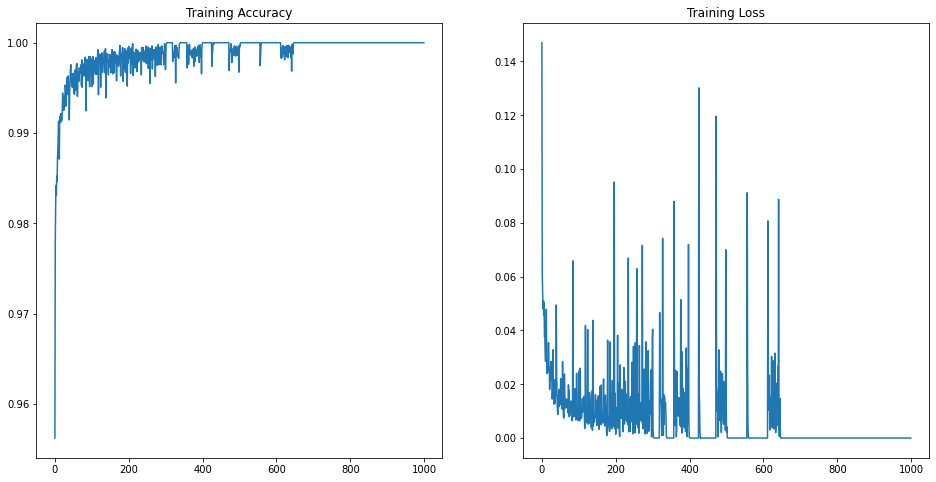

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.show()

## Обучение с тренировочной и валидационной подвыборками

In [ ]:
class_names = ['bluzy', 'bryuki']
num_classes = len(class_names)

model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Dense(100),
    Dense(100),
    Dense(100),
    Flatten(),
    Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_with_val.log', separator=',', append=False)

In [ ]:
epochs = 1000
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[csv_logger]
)

Epoch 1/1000
369/369 [==============================] - 3135s 3s/step - loss: 0.2308 - accuracy: 0.9411 - val_loss: 0.0693 - val_accuracy: 0.9751
Epoch 2/1000
369/369 [==============================] - 4s 12ms/step - loss: 0.0566 - accuracy: 0.9796 - val_loss: 0.0632 - val_accuracy: 0.9784
Epoch 3/1000
369/369 [==============================] - 4s 11ms/step - loss: 0.0483 - accuracy: 0.9839 - val_loss: 0.0560 - val_accuracy: 0.9810
Epoch 4/1000
369/369 [==============================] - 4s 10ms/step - loss: 0.0481 - accuracy: 0.9838 - val_loss: 0.0565 - val_accuracy: 0.9812
Epoch 5/1000
369/369 [==============================] - 4s 12ms/step - loss: 0.0604 - accuracy: 0.9808 - val_loss: 0.0868 - val_accuracy: 0.9759
Epoch 6/1000
369/369 [==============================] - 4s 10ms/step - loss: 0.0411 - accuracy: 0.9857 - val_loss: 0.0568 - val_accuracy: 0.9814
Epoch 7/1000
369/369 [==============================] - 4s 10ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 0.0526 - val_a

In [ ]:
from tensorflow import keras
model = keras.models.load_model('my_model_with_train_val_GPU_v2.h5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored